In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from glob import glob
import torch.backends.cudnn as cudnn
from modules.vgg import vgg16_bn
from modules.new_vgg import new_vgg16

from modules.vgg import vgg16_bn
from modules.resnet import resnet50, resnet101
import matplotlib.cm
from matplotlib.cm import ScalarMappable
import argparse
import easydict
import os

from utils.config import *
from utils.count_model import *
from datasets.cifar100 import *


def compute_pred(output):
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    print('Pred cls : '+str(pred))
    T = pred.squeeze().cpu().numpy()
    T = np.expand_dims(T, 0)
    T = (T[:, np.newaxis] == np.arange(100)) * 1.0
    T = torch.from_numpy(T).type(torch.FloatTensor)
    Tt = Variable(T).cuda()
    return Tt


config = easydict.EasyDict()
config.exp_name = "vgg16_exp_cifar100_0"
config.log_dir = os.path.join("experiments", config.exp_name, "logs/")

config.load_file = os.path.join("experiments", "vgg16_exp_cifar100_0","checkpoints", "checkpoint.pth")
config.cuda = True
config.gpu_device = 0
config.seed = 1
config.milestones = [10, 15, 20 , 25]
config.gamma = 0.9
config.img_size = 32
config.num_classes = 100
config.data_mode = "download"
config.data_loader_workers = 4
config.pin_memory = True
config.async_loading = True
config.batch_size = 128
config.async_loading = True
config.max_epoch = 30
torch.cuda.init()

cudnn.benchmark = True

num_workers = 0
batch_size = 1

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# define data loader
data_loader = Selected_Cifar100DataLoader(config)

# define model
model = vgg16_bn(input_shape=config.img_size, num_classes=config.num_classes, data_set='Cifar100')
model.load_checkpoint(config.load_file)
model.init_graph(config)

# method = LRP or RAP
method = 'LRP'

is_cuda = torch.cuda.is_available()
if is_cuda and not config.cuda:
    print("WARNING: You have a CUDA device, so you should probably enable CUDA")
cuda = is_cuda & config.cuda
manual_seed = config.seed
if cuda:
    device = torch.device("cuda")
    torch.cuda.manual_seed(manual_seed)
    torch.cuda.set_device(config.gpu_device)

print(model)
model = model.to(device)

# evaluate
model.eval()

Files already downloaded and verified
32 100 Cifar100
Loading checkpoint 'experiments\vgg16_exp_cifar100_0\checkpoints\checkpoint.pth'
Checkpoint loaded successfully at (epoch 240) at (iteration 93840)

Program will run on *****GPU-CUDA*****

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [2]:
new_model = new_vgg16(num_classes = 100)
new_model.init_graph(config)
new_model.load_checkpoint(config.load_file)
new_model = new_model.to(device)

Program will run on *****GPU-CUDA*****

Loading checkpoint 'experiments\vgg16_exp_cifar100_0\checkpoints\checkpoint.pth'
Checkpoint loaded successfully at (epoch 240) at (iteration 93840)



In [3]:
import pickle

with open('Record_relevance_VGG16_Transform_3class_top20_1.txt', 'rb') as f:
    record_stayed_nodes = pickle.load(f) # 단 한줄씩 읽어옴

In [4]:
record_stayed_nodes.shape

(300, 20, 17)

In [5]:
indices_stayed_list =[]

for i in range(1,17):
    indices_stayed_list.append(set(np.unique(record_stayed_nodes[:,:4,i])))

In [6]:
stayed_list = []

def truncate_str(x, cnt):
    new_list = []
    for i in x:
        item = i[cnt:]
        new_list.append(int(item))
    return new_list

for i in range(16):
    if i < 6:
        stayed_list.append(truncate_str(indices_stayed_list[i], cnt = 4))
    else:
        stayed_list.append(truncate_str(indices_stayed_list[i], cnt = 3))


In [7]:
from prune.channel import *

In [8]:
for i, m in enumerate(new_model.named_conv_list.values()):
    if isinstance(m, torch.nn.Conv2d) and i >0 :
        bn = new_model.named_modules_list[str(i) + '.bn']
        if str(i + 1) + '.conv' in model.named_conv_list:
            next_m = new_model.named_modules_list[str(i + 1) + '.conv']
        else:
            next_m = new_model.classifier[0]

        indices_stayed = sorted(stayed_list[-(i+2)])
        print(m)
        print(next_m)
        print(len(indices_stayed))
        module_surgery(m, bn, next_m, indices_stayed)
        
# cnt = 1
# for idx, m in enumerate(reversed(model.total_module_list)):
#     if 12<idx<15:

#         next_m = model.total_module_list[cnt]
#         indices_stayed= sorted(stayed_list[cnt])
#         linear_surgery(m, next_m,  indices_stayed)
#         cnt -= 1  
#         print(m)
#         print(next_m)
#         print(len(indices_stayed))

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14
Conv2d(14, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
62
Conv2d(62, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
77
Conv2d(77, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
127
Conv2d(127, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
155
Conv2d(155, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
153
Conv2d(153, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
226
Conv2d(226, 512, kernel_size=

In [9]:
best_valid_acc, history  = new_model.model_train(config)

Files already downloaded and verified


Valiation at -0-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-0 | loss: 4.412174574859307	Top1 Acc: 0.06511999999761582


Valiation at -0-: 100%|████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.39it/s]
C:\Users\USER001\miniconda3\envs\pytorch16\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch-1-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-0 | loss: 4.073745326150822	Top1 Acc: 0.1249


Valiation at -1-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-1 | loss: 3.890758554648865	Top1 Acc: 0.15027999999523162


Epoch-2-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-1 | loss: 3.60138918176482	Top1 Acc: 0.192


Valiation at -2-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-2 | loss: 3.4174137670365745	Top1 Acc: 0.2406200000190735


Epoch-3-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-2 | loss: 3.090388593794424	Top1 Acc: 0.3057


Valiation at -3-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-3 | loss: 2.879962343693999	Top1 Acc: 0.35461999999046323


Epoch-4-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-3 | loss: 2.53737015663823	Top1 Acc: 0.4169


Valiation at -4-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-4 | loss: 2.3287014214279096	Top1 Acc: 0.46972000002861025


Epoch-5-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-4 | loss: 2.0929871390137493	Top1 Acc: 0.5024


Valiation at -5-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-5 | loss: 1.8922135464065826	Top1 Acc: 0.5533600000190735


Epoch-6-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-5 | loss: 1.8171377423443371	Top1 Acc: 0.5557


Valiation at -6-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-6 | loss: 1.5889117345785546	Top1 Acc: 0.6089600000572205


Epoch-7-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-6 | loss: 1.645741651329813	Top1 Acc: 0.5891


Valiation at -7-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-7 | loss: 1.3830406412749034	Top1 Acc: 0.6513199999809265


Epoch-8-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-7 | loss: 1.5511312318753592	Top1 Acc: 0.603


Valiation at -8-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-8 | loss: 1.240836457065914	Top1 Acc: 0.6810000000190735


Epoch-9-:   0%|                                                                                | 0/391 [00:00<?, ?it/s]

Validation results at epoch-8 | loss: 1.5079861245577848	Top1 Acc: 0.6154


Valiation at -9-:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Training at epoch-9 | loss: 1.1251485757815562	Top1 Acc: 0.7050600000190735


Epoch-10-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-9 | loss: 1.481308184092558	Top1 Acc: 0.6202


Valiation at -10-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-10 | loss: 1.0407763161622654	Top1 Acc: 0.726160000038147


Epoch-11-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-10 | loss: 1.4425620398943937	Top1 Acc: 0.6305


Valiation at -11-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-11 | loss: 0.952728780334258	Top1 Acc: 0.74488


Epoch-12-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-11 | loss: 1.4334460768518569	Top1 Acc: 0.6368


Valiation at -12-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-12 | loss: 0.8887912377981884	Top1 Acc: 0.75974


Epoch-13-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-12 | loss: 1.415585800062252	Top1 Acc: 0.6391


Valiation at -13-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-13 | loss: 0.8488002556669133	Top1 Acc: 0.7685399999809265


Epoch-14-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-13 | loss: 1.4141895182525055	Top1 Acc: 0.6414


Valiation at -14-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-14 | loss: 0.8043243234114879	Top1 Acc: 0.7783200000190735


Epoch-15-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-14 | loss: 1.444866324527354	Top1 Acc: 0.6367


Valiation at -15-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-15 | loss: 0.768565565500113	Top1 Acc: 0.7856800000190735


Epoch-16-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-15 | loss: 1.4223177206667164	Top1 Acc: 0.6421


Valiation at -16-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-16 | loss: 0.7234260252369639	Top1 Acc: 0.7999199999809266


Epoch-17-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-16 | loss: 1.4290766368938397	Top1 Acc: 0.6448


Valiation at -17-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-17 | loss: 0.6881627240754149	Top1 Acc: 0.80582


Epoch-18-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-17 | loss: 1.4110784485370298	Top1 Acc: 0.6491


Valiation at -18-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-18 | loss: 0.6668217195116956	Top1 Acc: 0.812140000038147


Epoch-19-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-18 | loss: 1.420605766622326	Top1 Acc: 0.6502


Valiation at -19-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-19 | loss: 0.6372637799023972	Top1 Acc: 0.820460000038147


Epoch-20-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-19 | loss: 1.4008822848525229	Top1 Acc: 0.6543


Valiation at -20-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-20 | loss: 0.6256213249910213	Top1 Acc: 0.8227000000572204


Epoch-21-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-20 | loss: 1.43239882626111	Top1 Acc: 0.6495


Valiation at -21-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-21 | loss: 0.5886024985167072	Top1 Acc: 0.8316000000572205


Epoch-22-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-21 | loss: 1.421092243134221	Top1 Acc: 0.6509


Valiation at -22-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-22 | loss: 0.5691203317221474	Top1 Acc: 0.8379000000572204


Epoch-23-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-22 | loss: 1.4087182856813263	Top1 Acc: 0.6516


Valiation at -23-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-23 | loss: 0.5601214343477088	Top1 Acc: 0.8376200000572205


Epoch-24-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-23 | loss: 1.4206610065472276	Top1 Acc: 0.6599


Valiation at -24-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-24 | loss: 0.5344986457120428	Top1 Acc: 0.8469399999809265


Epoch-25-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-24 | loss: 1.4227902406378636	Top1 Acc: 0.6601


Valiation at -25-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-25 | loss: 0.5120061087181501	Top1 Acc: 0.85212


Epoch-26-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-25 | loss: 1.415594808662994	Top1 Acc: 0.6587


Valiation at -26-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-26 | loss: 0.49108364034796614	Top1 Acc: 0.8577799999809265


Epoch-27-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-26 | loss: 1.4523749487309516	Top1 Acc: 0.6564


Valiation at -27-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-27 | loss: 0.47203568336756335	Top1 Acc: 0.8639000000190735


Epoch-28-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-27 | loss: 1.42950783952882	Top1 Acc: 0.6603


Valiation at -28-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-28 | loss: 0.4655297397042784	Top1 Acc: 0.8642200000572204


Epoch-29-:   0%|                                                                               | 0/391 [00:00<?, ?it/s]

Validation results at epoch-28 | loss: 1.4481663205955602	Top1 Acc: 0.6574


Valiation at -29-:   0%|                                                                        | 0/79 [00:00<?, ?it/s]

Training at epoch-29 | loss: 0.4584489378249249	Top1 Acc: 0.866860000038147


Valiation at -29-: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 21.22it/s]

Validation results at epoch-29 | loss: 1.4606823785395562	Top1 Acc: 0.6571


In [10]:
best_valid_acc

0.6603

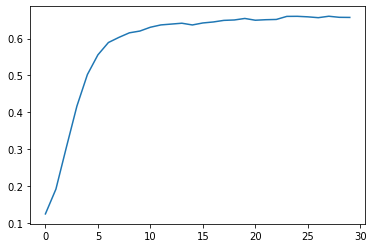

In [11]:
import matplotlib.pyplot as plt
plt.plot(history)

In [12]:
from torchsummaryX import summary
summary(new_model, torch.zeros((1, 3, 32, 32)).to(device))

                                Kernel Shape     Output Shape    Params  \
Layer                                                                     
0_features.Conv2d_0            [3, 64, 3, 3]  [1, 64, 32, 32]    1.792k   
1_features.BatchNorm2d_1                [64]  [1, 64, 32, 32]     128.0   
2_features.ReLU_2                          -  [1, 64, 32, 32]         -   
3_features.Conv2d_3           [64, 14, 3, 3]  [1, 14, 32, 32]    8.078k   
4_features.BatchNorm2d_4                [14]  [1, 14, 32, 32]      28.0   
5_features.ReLU_5                          -  [1, 14, 32, 32]         -   
6_features.MaxPool2d_6                     -  [1, 14, 16, 16]         -   
7_features.Conv2d_7           [14, 62, 3, 3]  [1, 62, 16, 16]    7.874k   
8_features.BatchNorm2d_8                [62]  [1, 62, 16, 16]     124.0   
9_features.ReLU_9                          -  [1, 62, 16, 16]         -   
10_features.Conv2d_10         [62, 77, 3, 3]  [1, 77, 16, 16]   43.043k   
11_features.BatchNorm2d_1

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_features.Conv2d_0,"[3, 64, 3, 3]","[1, 64, 32, 32]",1792.0,1769472.0
1_features.BatchNorm2d_1,[64],"[1, 64, 32, 32]",128.0,64.0
2_features.ReLU_2,-,"[1, 64, 32, 32]",NaN,NaN
3_features.Conv2d_3,"[64, 14, 3, 3]","[1, 14, 32, 32]",8078.0,8257536.0
4_features.BatchNorm2d_4,[14],"[1, 14, 32, 32]",28.0,14.0
5_features.ReLU_5,-,"[1, 14, 32, 32]",NaN,NaN
6_features.MaxPool2d_6,-,"[1, 14, 16, 16]",NaN,NaN
7_features.Conv2d_7,"[14, 62, 3, 3]","[1, 62, 16, 16]",7874.0,1999872.0
8_features.BatchNorm2d_8,[62],"[1, 62, 16, 16]",124.0,62.0


In [13]:
for i in history:
    print(i)

0.1249
0.192
0.3057
0.4169
0.5024
0.5557
0.5891
0.603
0.6154
0.6202
0.6305
0.6368
0.6391
0.6414
0.6367
0.6421
0.6448
0.6491
0.6502
0.6543
0.6495
0.6509
0.6516
0.6599
0.6601
0.6587
0.6564
0.6603
0.6574
0.6571


In [14]:
332.484736*0.2

66.49694720000001